In [1]:
#################################################
#Spectral analysis and Change Detection Practice#
#Maintainer: Christopher Chan                   #
#Date: 2024-06-07                               #
#Version: 0.0.2                                 #
#################################################

import os, sys
import pysal
import pygis
import pathlib
import earthpy
import pyproj

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import seaborn as sns
import earthpy as et
import earthpy.plot as ep
import matplotlib.pyplot as plt

from rasterio.plot import show
from shapely.geometry import shape
%matplotlib inline

data_path = pathlib.Path("../data")
raster_inter = pathlib.Path("../data/02_intermediate/raster/L2A_Eliburn_2024-06-05 23_17_20.602139")

## Masking and preprocessing

(92, 136)
(92, 136)
16
(92, 136)


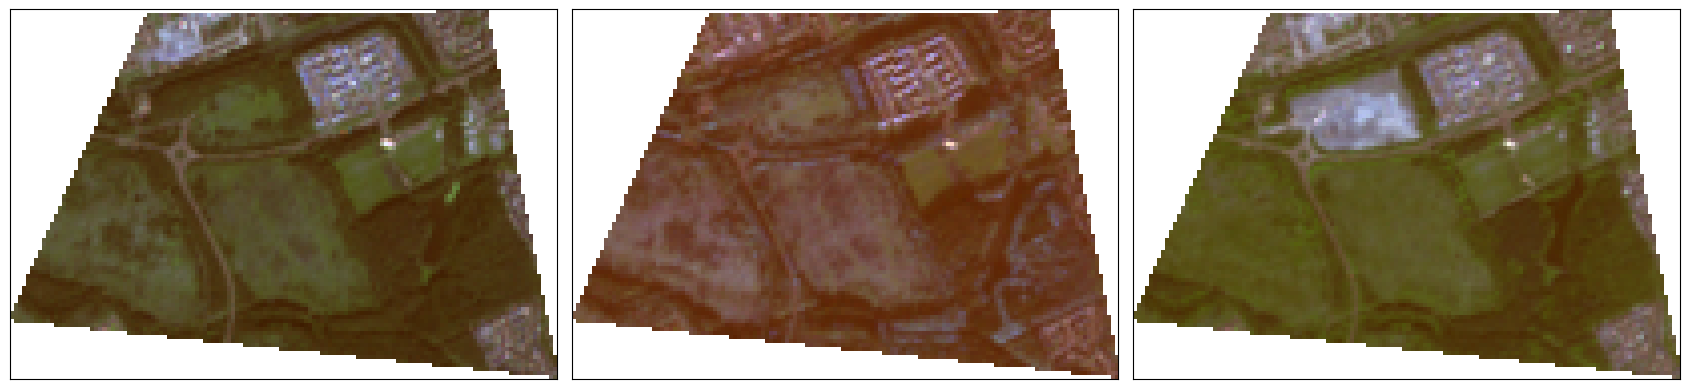

In [10]:
with rio.open(f"{raster_inter}/L2A_Eliburn_2024-05-18.tif", "r+", driver = "GTiff", crs = "EPSG:27700") as src:
    transform = src.transform
    crs = src.crs
    b2, b3, b4, b8 = src.read(2).astype("float32"), src.read(3).astype("float32"), src.read(4).astype("float32"), src.read(8).astype("float32")
    b8a, b11 = src.read(9).astype("float32"), src.read(12).astype("float32")
    print(src.shape)
    rgb_20240518 = np.stack((b2, b3, b4))
    # Built (RED-BLUE), NDBI(SWIR-NIR)
    builtRB_20240518 = (b4-b2)/(b4+b2)
    ndbi_20240518 = (b11-b8)/(b11+b8)
    ndwi_20240518 = (b3-b8)/(b3+b8)
    ndvi_20240518 = (b8-b4)/(b8+b4)
    
with rio.open(f"{raster_inter}/L2A_Eliburn_2023-11-05.tif", "r+", driver = "GTiff", crs = "EPSG:27700") as src:
    b2, b3, b4, b8 = src.read(2).astype("float32"), src.read(3).astype("float32"), src.read(4).astype("float32"), src.read(8).astype("float32")
    b8a, b11 = src.read(9).astype("float32"), src.read(12).astype("float32")
    print(src.shape)
    rgb_20231105 = np.stack((b2, b3, b4))
    builtRB_20231105 = (b4-b2)/(b4+b2)
    ndbi_20231105 = (b11-b8)/(b11+b8)
    ndwi_20231105 = (b3-b8)/(b3+b8)
    ndvi_20231105 = (b8-b4)/(b8+b4)

with rio.open(f"{raster_inter}/L2A_Eliburn_2023-09-04.tif", "r+", driver = "GTiff", crs = "EPSG:27700") as src:
    b2, b3, b4, b8 = src.read(2).astype("float32"), src.read(3).astype("float32"), src.read(4).astype("float32"), src.read(8).astype("float32")
    b8a, b11 = src.read(9).astype("float32"), src.read(12).astype("float32")
    print(src.count)
    print(src.shape)
    rgb_20230904 = np.stack((b2, b3, b4))
    builtRB_20230904 = (b4-b2)/(b4+b2)
    ndbi_20230904 = (b11-b8)/(b11+b8)
    ndwi_20230904 = (b3-b8)/(b3+b8)
    ndvi_20230904 = (b8-b4)/(b8+b4)

fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_rgb(rgb_20230904, ax=ax[0])
ep.plot_rgb(rgb_20231105, ax=ax[1])
ep.plot_rgb(rgb_20240518, ax=ax[2])

plt.tight_layout()
plt.show()


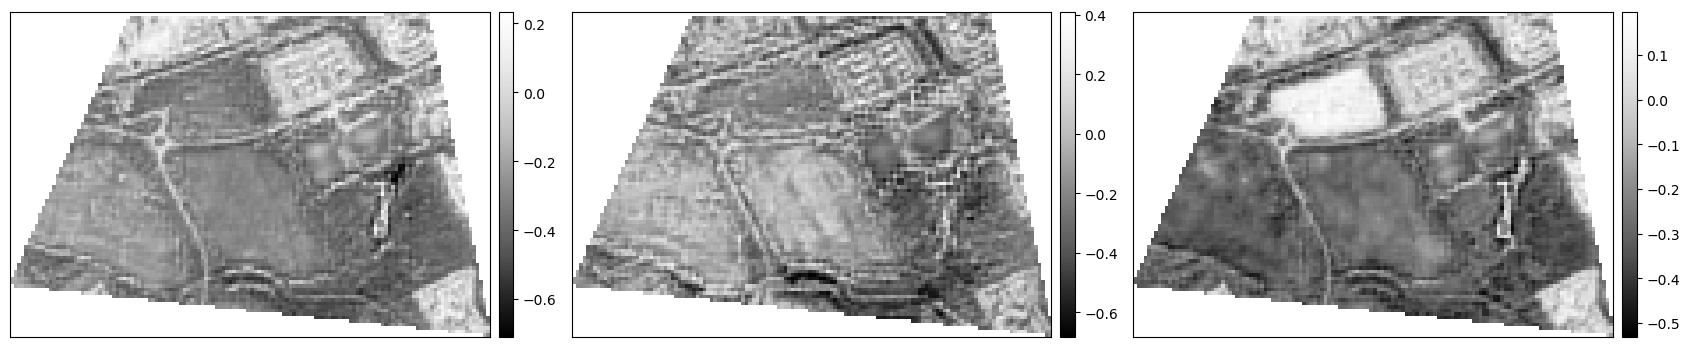

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_bands(ndbi_20230904, ax=ax[0])
ep.plot_bands(ndbi_20231105, ax=ax[1])
ep.plot_bands(ndbi_20240518, ax=ax[2])

plt.tight_layout()
plt.show()

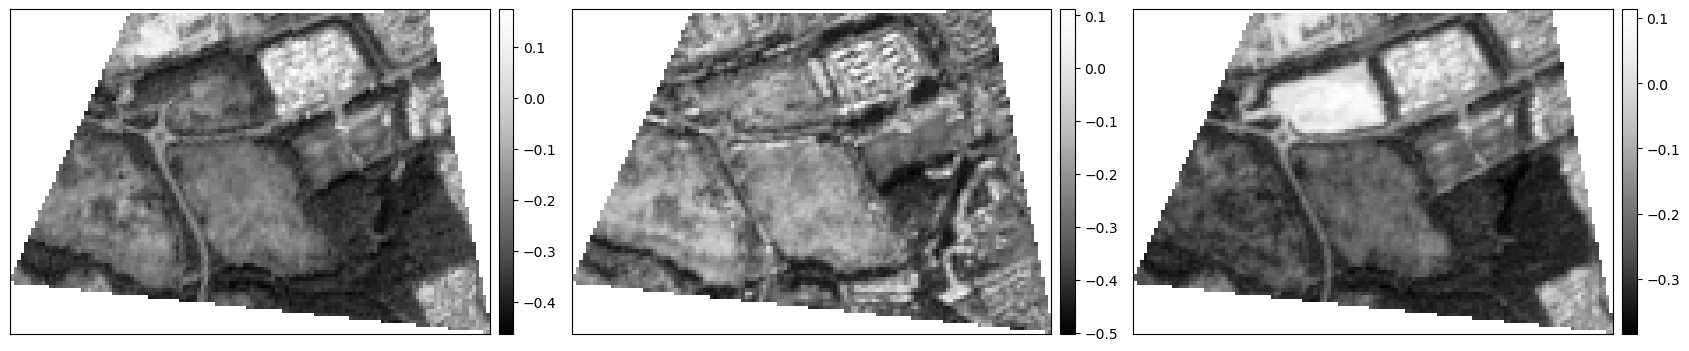

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_bands(builtRB_20230904, ax=ax[0])
ep.plot_bands(builtRB_20231105, ax=ax[1])
ep.plot_bands(builtRB_20240518, ax=ax[2])

plt.tight_layout()
plt.show()

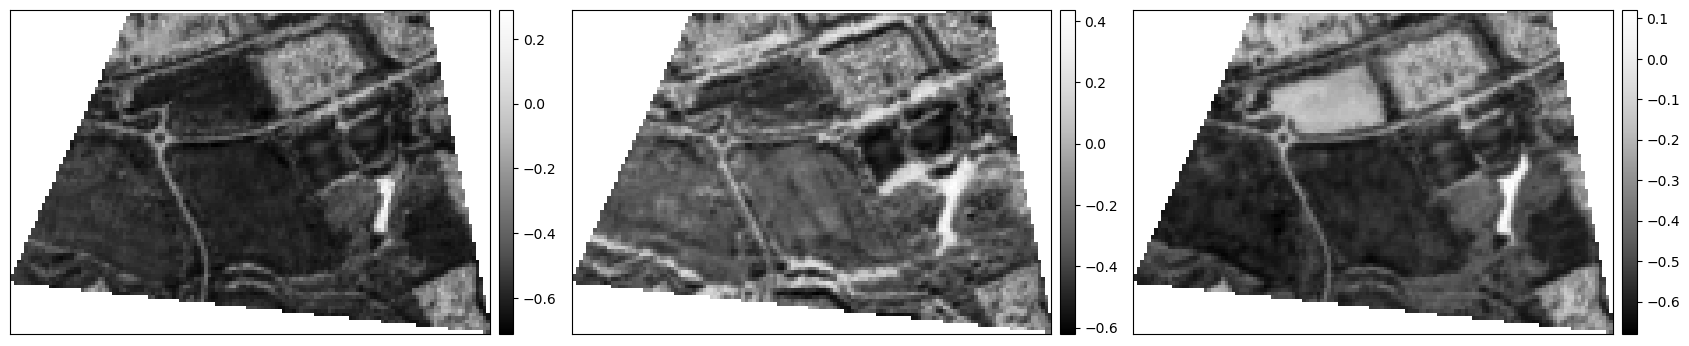

In [13]:
#NDWI
fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_bands(ndwi_20230904, ax=ax[0])
ep.plot_bands(ndwi_20231105, ax=ax[1])
ep.plot_bands(ndwi_20240518, ax=ax[2])

plt.tight_layout()
plt.show()

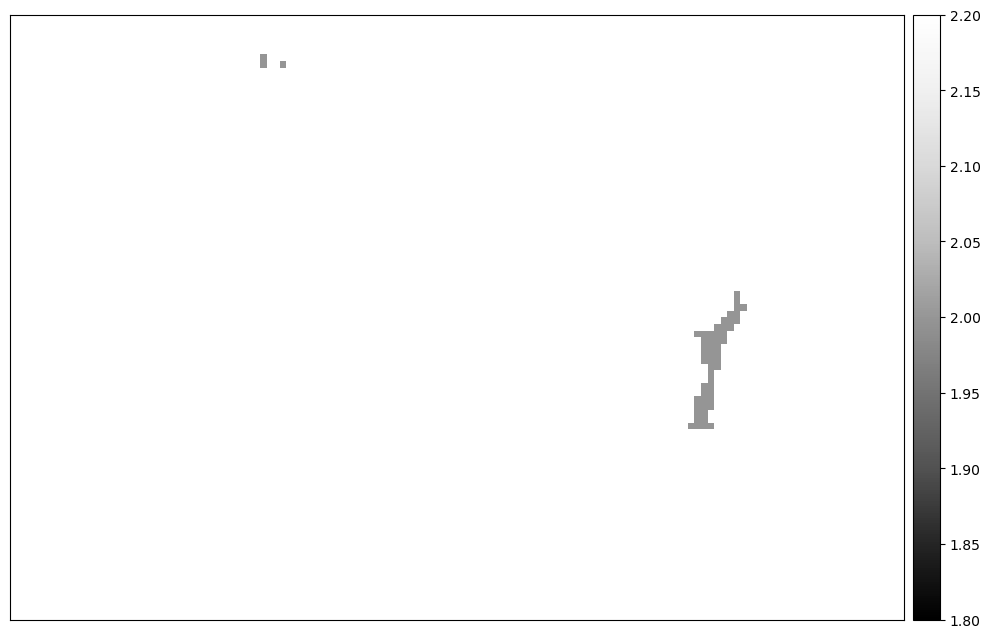

<Axes: >

In [16]:
water_20240518 = np.where(ndwi_20240518 > -0.1, 2, np.nan)

with rio.open(f"{data_path}/02_intermediate/raster/water_20240518.tif", "w", 
              height=water_20240518.shape[0], width=water_20240518.shape[1],
              count=1, dtype=water_20240518.dtype,
              crs="EPSG:27700",
              driver="GTiff") as dest:
    dest.write(water_20240518, 1)

ep.plot_bands(water_20240518)

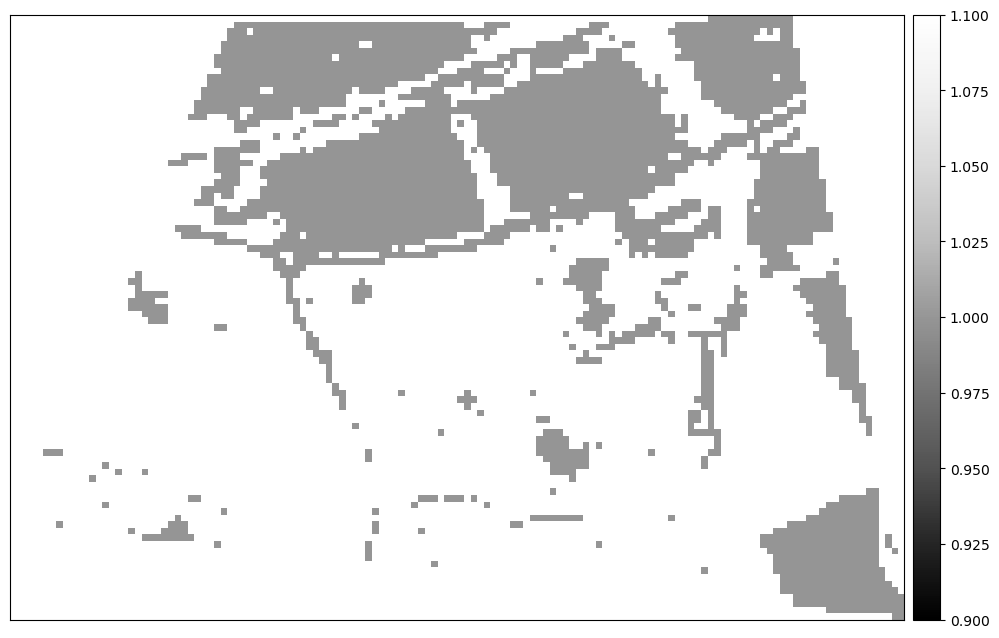

<Axes: >

In [17]:
# Replace urban areas with 1, else 0
built_20240518 = np.where(ndbi_20240518 > -0.2 ,1, np.nan)

with rio.open(f"{data_path}/02_intermediate/raster/built_20240518.tif", "w", 
              height=built_20240518.shape[0], width=built_20240518.shape[1],
              count=1, dtype=built_20240518.dtype,
              crs="EPSG:27700",
              driver="GTiff") as dest:
    dest.write(built_20240518, 1)

ep.plot_bands(built_20240518)

In [18]:
!gdal_polygonize.py ~/Proj/geospatial/data/02_intermediate/raster/built_20240518.tif -b 1 -f "GeoJSON" ~/Proj/geospatial/data/02_intermediate/vector/built_20240518.geojson built_20240518 DN

0...10...20...30...40...50...60...70...80...90...100 - done.


In [19]:
# Polygonise water
water_shapes = list(rio.features.shapes(water_20240518.astype("float32"), mask=None, transform=transform, connectivity=4))
print(water_shapes)

DFwater_20240518 = pd.DataFrame(water_shapes, columns = ["geometry", "value"])
DFwater_20240518['geometry'] = DFwater_20240518['geometry'].apply(lambda x: shape(x))
GDFwater_20240518 = gpd.GeoDataFrame(DFwater_20240518, geometry='geometry', crs="EPSG:27700")

GDFwater_20240518.to_file(f"{data_path}/02_intermediate/vector/GDFwater_20240518.geojson", driver="GeoJSON")

# Polygonise building
built_shapes = list(rio.features.shapes(built_20240518.astype("float32"), mask=None, transform=transform, connectivity=4))
print(built_shapes)

DFbuilt_20240518 = pd.DataFrame(built_shapes, columns = ["geometry", "value"])
DFbuilt_20240518['geometry'] = DFbuilt_20240518['geometry'].apply(lambda x: shape(x))
GDFbuilt_20240518 = gpd.GeoDataFrame(DFbuilt_20240518, geometry='geometry', crs="EPSG:27700")

GDFbuilt_20240518.to_file(f"{data_path}/02_intermediate/vector/GDFbuilt_20240518.geojson", driver="GeoJSON")

features_20240518 = pd.concat([GDFbuilt_20240518, GDFwater_20240518], ignore_index=True)

[({'type': 'Polygon', 'coordinates': [[(302440.0, 668320.0), (302440.0, 668300.0), (302450.0, 668300.0), (302450.0, 668320.0), (302440.0, 668320.0)]]}, 2.0), ({'type': 'Polygon', 'coordinates': [[(302470.0, 668310.0), (302470.0, 668300.0), (302480.0, 668300.0), (302480.0, 668310.0), (302470.0, 668310.0)]]}, 2.0), ({'type': 'Polygon', 'coordinates': [[(303160.0, 667960.0), (303160.0, 667930.0), (303150.0, 667930.0), (303150.0, 667920.0), (303140.0, 667920.0), (303140.0, 667910.0), (303130.0, 667910.0), (303130.0, 667900.0), (303100.0, 667900.0), (303100.0, 667890.0), (303110.0, 667890.0), (303110.0, 667850.0), (303120.0, 667850.0), (303120.0, 667820.0), (303110.0, 667820.0), (303110.0, 667800.0), (303100.0, 667800.0), (303100.0, 667760.0), (303090.0, 667760.0), (303090.0, 667750.0), (303130.0, 667750.0), (303130.0, 667760.0), (303120.0, 667760.0), (303120.0, 667780.0), (303130.0, 667780.0), (303130.0, 667840.0), (303140.0, 667840.0), (303140.0, 667880.0), (303150.0, 667880.0), (303150.0

In [20]:
features_20240518.explore("value", tiles="OpenStreetMap", legend=True)